In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline


from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
train = pd.read_csv("train/train.csv")

In [3]:
test = pd.read_csv("test.csv")

In [4]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [5]:
train.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [6]:
train['week'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145])

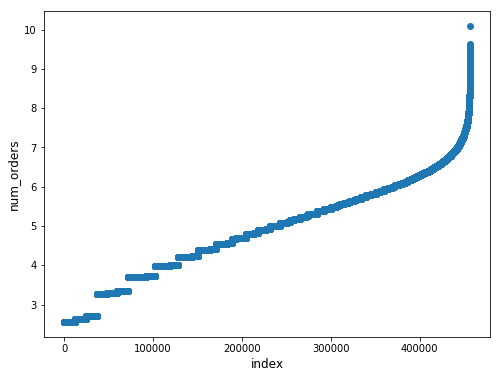

In [7]:
target_col = "num_orders"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(np.log(train[target_col].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('num_orders', fontsize=12)
plt.show()

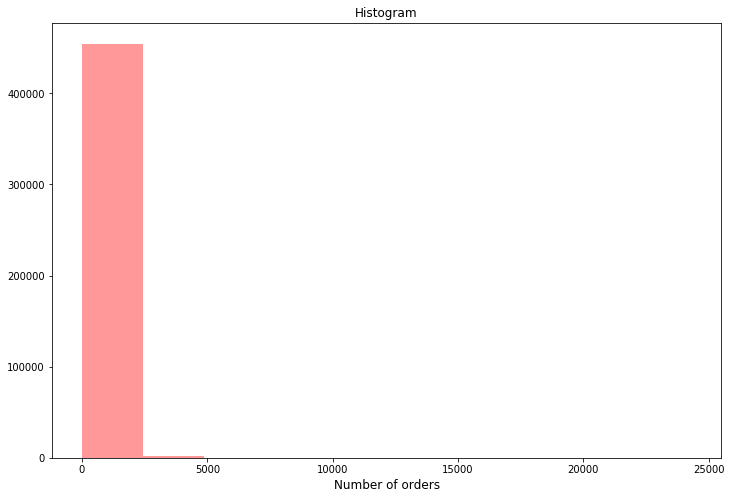

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col].values, bins=10, kde=False, color="red")
plt.title("Histogram")
plt.xlabel('Number of orders', fontsize=12)
plt.show()

In [9]:
meal = pd.read_csv("train/meal_info.csv")
center = pd.read_csv("train/fulfilment_center_info.csv")

In [10]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [11]:
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [12]:
train['discount'] = train['base_price'] - train['checkout_price']

In [13]:
train['discount_per'] = train['discount'] / train['base_price']

In [14]:
test['discount'] = test['base_price'] - test['checkout_price']
test['discount_per'] = test['discount'] / test['base_price']

In [15]:
train_df = train.merge(meal, on = 'meal_id', how = 'left').merge(center, on = 'center_id', how = 'left')
test_df = test.merge(meal, on = 'meal_id', how = 'left').merge(center, on = 'center_id', how = 'left')

In [16]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,discount_per,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,15.46,0.101517,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,-1.00,-0.007362,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,1.00,0.007361,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,98.03,0.224053,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,-1.00,-0.004124,Beverages,Indian,647,56,TYPE_C,2.0


In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
categorical_variables = []
for colname in train_df.columns:
    if train_df[colname].dtype == "object":
        categorical_variables.append(colname)
        print("Categorical Variable: %s, No. Categories: %d" % (colname, len(np.unique(train_df[colname].values.astype("str")))))

Categorical Variable: category, No. Categories: 14
Categorical Variable: cuisine, No. Categories: 4
Categorical Variable: center_type, No. Categories: 3


In [19]:
train_df = pd.get_dummies(train_df, columns=['category','cuisine','center_type'])
test_df = pd.get_dummies(test_df, columns=['category','cuisine','center_type'])

In [20]:
def features(df):
    agg_func = {
    'id' : ['nunique']
    }
    agg_df1 = df.groupby(['week','center_id'])['id'].count()
    agg_df1 = agg_df1.reset_index()
    agg_df1 = agg_df1.rename(columns = {'id':'unique_week_center'})
    
    agg_df2 = df.groupby(['week','meal_id'])['id'].count()
    agg_df2 = agg_df2.reset_index()
    agg_df2 = agg_df2.rename(columns = {'id':'unique_week_meal'})
    
    agg_df3 = df.groupby(['week','city_code'])['id'].count()
    agg_df3 = agg_df3.reset_index()
    agg_df3 = agg_df3.rename(columns = {'id':'unique_week_city'})
    return agg_df1, agg_df2, agg_df3

In [21]:
train_agg_df1, train_agg_df2, train_agg_df3 = features(train_df)

In [22]:
train_df = train_df.merge(train_agg_df1, on = ['week','center_id'], how = 'left')
train_df = train_df.merge(train_agg_df2, on = ['week','meal_id'], how = 'left')
train_df = train_df.merge(train_agg_df3, on = ['week','city_code'], how = 'left')

In [23]:
test_agg_df1, test_agg_df2, test_agg_df3 = features(test_df)

In [24]:
test_df = test_df.merge(test_agg_df1, on = ['week','center_id'], how = 'left')
test_df = test_df.merge(test_agg_df2, on = ['week','meal_id'], how = 'left')
test_df = test_df.merge(test_agg_df3, on = ['week','city_code'], how = 'left')

In [25]:
train_df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'discount',
       'discount_per', 'city_code', 'region_code', 'op_area',
       'category_Beverages', 'category_Biryani', 'category_Desert',
       'category_Extras', 'category_Fish', 'category_Other Snacks',
       'category_Pasta', 'category_Pizza', 'category_Rice Bowl',
       'category_Salad', 'category_Sandwich', 'category_Seafood',
       'category_Soup', 'category_Starters', 'cuisine_Continental',
       'cuisine_Indian', 'cuisine_Italian', 'cuisine_Thai',
       'center_type_TYPE_A', 'center_type_TYPE_B', 'center_type_TYPE_C',
       'unique_week_center', 'unique_week_meal', 'unique_week_city'],
      dtype='object')

In [26]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "boosting": "gbdt",
        "num_leaves" : 100,
        "max_depth" : 25,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.9,
        "bagging_frequency" : 5,
        "bagging_seed" : 7979,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=np.log(train_y))
    lgval = lgb.Dataset(val_X, label=np.log(val_y))
    evals_result = {}
    model = lgb.train(params, lgtrain, 3000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [27]:
feature_cols = ['center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'discount',
       'discount_per', 'city_code', 'region_code', 'op_area',
       'category_Beverages', 'category_Biryani', 'category_Desert',
       'category_Extras', 'category_Fish', 'category_Other Snacks',
       'category_Pasta', 'category_Pizza', 'category_Rice Bowl',
       'category_Salad', 'category_Sandwich', 'category_Seafood',
       'category_Soup', 'category_Starters', 'cuisine_Continental',
       'cuisine_Indian', 'cuisine_Italian', 'cuisine_Thai',
       'center_type_TYPE_A', 'center_type_TYPE_B', 'center_type_TYPE_C',
    'unique_week_meal', 'unique_week_city']

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
#train_df1 = train_df[train_df['week']<=140]
#train_df2 = train_df[train_df['week']>140]
train_df1 = train_df

In [30]:
train_X = train_df1[feature_cols]
#val_X1 = train_df2[feature_cols]
test_X = test_df[feature_cols]
train_y = train_df1['num_orders'].values
#val_y1 = train_df2['num_orders'].values

In [ ]:
pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=6969, shuffle=True)
for dev_index, val_index in kf.split(train_df1):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.532401
[200]	valid_0's rmse: 0.505909
[300]	valid_0's rmse: 0.497005
[400]	valid_0's rmse: 0.490813
[500]	valid_0's rmse: 0.48661
[600]	valid_0's rmse: 0.483916
[700]	valid_0's rmse: 0.481709
[800]	valid_0's rmse: 0.480101
[900]	valid_0's rmse: 0.478742
[1000]	valid_0's rmse: 0.477495
[1100]	valid_0's rmse: 0.476426
[1200]	valid_0's rmse: 0.475657
[1300]	valid_0's rmse: 0.474873
[1400]	valid_0's rmse: 0.474125
[1500]	valid_0's rmse: 0.473539
[1600]	valid_0's rmse: 0.472936
[1700]	valid_0's rmse: 0.472505
[1800]	valid_0's rmse: 0.472089
[1900]	valid_0's rmse: 0.471685
[2000]	valid_0's rmse: 0.47136
[2100]	valid_0's rmse: 0.47113
[2200]	valid_0's rmse: 0.470863
[2300]	valid_0's rmse: 0.470608
[2400]	valid_0's rmse: 0.470547
[2500]	valid_0's rmse: 0.470423
[2600]	valid_0's rmse: 0.470352
[2700]	valid_0's rmse: 0.470269
[2800]	valid_0's rmse: 0.470223
[2900]	valid_0's rmse: 0.47017
[3000]	valid_0's rmse:

In [ ]:
#metrics.mean_squared_log_error(val_y1,np.round(np.exp(model.predict(val_X1, num_iteration=model.best_iteration))))

In [ ]:
sub_df = pd.DataFrame({"id":test_df["id"].values})
sub_df["num_orders"] = np.round(np.exp(pred_test), decimals=0)
sub_df.to_csv("log_trans_lgb7.csv", index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()